# Current solution uses multiprocessing in Python to create the matrix

Here is the list of things to benchmark:

- shapely vs wkt 
- matrix containing qgisGeometry ==> update vlayer using enumerate rather than dict 


# Wkt vs Shapely point 
To measure : 
. size in memory of matrix
. Time to build matrix 
. Time for ONF to create the new geometry


### Wkt vs Shapely point

Does the wkt transformation takes longer than the if checks to see if Point is empty in ONF ? 


### Matrix with  QgsGeometry

This is somewhat cumbersome to implement : requires passing the Pyqgis path to the worker nodes to create the QgsGeometries



# ONF Shapely Point and QgsPointXY

```python
from shapely.geometry import Point
import time

Timer = 0
n = 20000
item = Point(0,0)
for i in range(n) :        
    now = time.time()
    x,y = item.x, item.y
    geom = QgsGeometry.fromPointXY(QgsPointXY(x,y))
    Timer += time.time() - now 
    
print(f"time over {n} : {Timer} s, average {Timer/n}")
```


Using WKT code :

```python
from shapely.geometry import Point
import time

Timer = 0
n = 20000
item = Point(0,0).wkt
for i in range(n) :        
    now = time.time()
    geom = QgsGeometry().fromWkt(item)
    Timer += time.time() - now 
    
print(f"time over {n} : {Timer} s, average {Timer/n}")

```

Results 

QgsPointXY:
exec(Path('/tmp/tmp5m0u71g5').read_text())
time over 20000 : 0.6315727233886719 s, average 3.1578636169433594e-05

Wkt: 

exec(Path('/tmp/tmp300ld8yj').read_text())
time over 20000 : 0.06986188888549805 s, average 3.4930944442749022e-06


Advantage for WKT 

# Matrix Shapely point vs WKT


TODO

# Removing datetime object update in ONF


Using these parameters :

. 0.2 % of boats
. tdelta size : 60 frames
. 150 frames animation



Before with single datetime attribute, requiring the update of the datetime at each frame of the temporal controller

tt.get_average_fps()
60.72075001983026

After adding a start-end datetime attribute field removing the attribute update at each ONF call

tt.get_average_fps()
71.28473220962775


TLDR :

-A noticeable improvement in ONF time 

# ONF FPS for N objects

Limit on ONF FPS optimization, how much time would it take to update geometries for x objects with x = [100, 1000, 5000, 10000, 15000, 20000]


### Method






In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import time

canvas = iface.mapCanvas()
temporalController = canvas.temporalController()



def create_vlayer(name, num_fields, frames):
    task_manager = QgsApplication.taskManager()
    vlayer = QgsVectorLayer("Point", name, "memory")
    pr = vlayer.dataProvider()
    pr.addAttributes([QgsField("start_time", QVariant.DateTime), QgsField("end_time", QVariant.DateTime)])
    vlayer.updateFields()
    tp = vlayer.temporalProperties()
    tp.setIsActive(True)
    tp.setMode(qgis.core.QgsVectorLayerTemporalProperties.ModeFeatureDateTimeStartAndEndFromFields)
    tp.setStartField("start_time")
    tp.setEndField("end_time")

    now = time.time()
    start_datetime_obj = QDateTime(datetime(2023,6,1,0,0,0))
    end_datetime_obj = QDateTime(datetime(2023,6,1,23,0,0))
    geom = QgsGeometry.fromPointXY(QgsPointXY(1, 1))
    fields = vlayer.fields()

    # features_list =[]
    # for i in range(num_fields):
    #     feat = QgsFeature(vlayer.fields())
    #     feat.setAttributes([start_datetime_obj, end_datetime_obj])

    #     feat.setGeometry(geom)
    #     features_list.append(feat)

    # Create features list
    features_list = [ QgsFeature(fields).setAttributes([start_datetime_obj, end_datetime_obj]).setGeometry(geom) for _ in range(num_fields) ]

    QgsProject.instance().addMapLayer(vlayer)
    
    
    vlayer.startEditing()
    vlayer.addFeatures(features_list)
    vlayer.commitChanges()
    iface.vectorLayerTools().stopEditing(vlayer)

    TIME_create_features = time.time() - now

    current_time_stamp_column = ["POINT (1 1)"]*num_fields

    fps_record = []
    for i in range(frames):
        start_time = time.time()    

        new_geometries = {}  # Dictionary {feature_id: QgsGeometry}
        for j in range(num_fields): #TODO : compare vs Nditer
            new_geometries[j] = QgsGeometry.fromWkt(current_time_stamp_column[j])


        vlayer.startEditing()
        # self.qviz.vlayer.dataProvider().changeAttributeValues(attribute_changes) # Updating attribute values for all features
        vlayer.dataProvider().changeGeometryValues(new_geometries) # Updating geometries for all features
        vlayer.commitChanges()
        iface.vectorLayerTools().stopEditing(vlayer)


        end_time = time.time()
        fps_record.append(1/(end_time-start_time))

    average_fps = sum(fps_record)/len(fps_record)
    
    return average_fps, TIME_create_features


x = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 100000]


frames = 100
results = {}
for i, x in enumerate(x):
    print(f"Average fps for {x} features over {frames} frames : ")
    avg_fps, create_time = create_vlayer(f"vlayer_{x}", x, frames)
    results[x] = (avg_fps, create_time)
    print(f"{avg_fps} fps")
    print("")

print(results)



num_objects = list(results.keys())
fps_values = [v[0] for v in results.values()]
generation_times = [v[1] for v in results.values()]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(num_objects, fps_values, label='FPS', marker='o')
plt.plot(num_objects, generation_times, label='Generation Time (s)', marker='o')

plt.xlabel('Number of Objects')
plt.ylabel('Values')
plt.title('FPS and Generation Time vs Number of Objects')
plt.legend()
plt.grid(True)

plt.show()

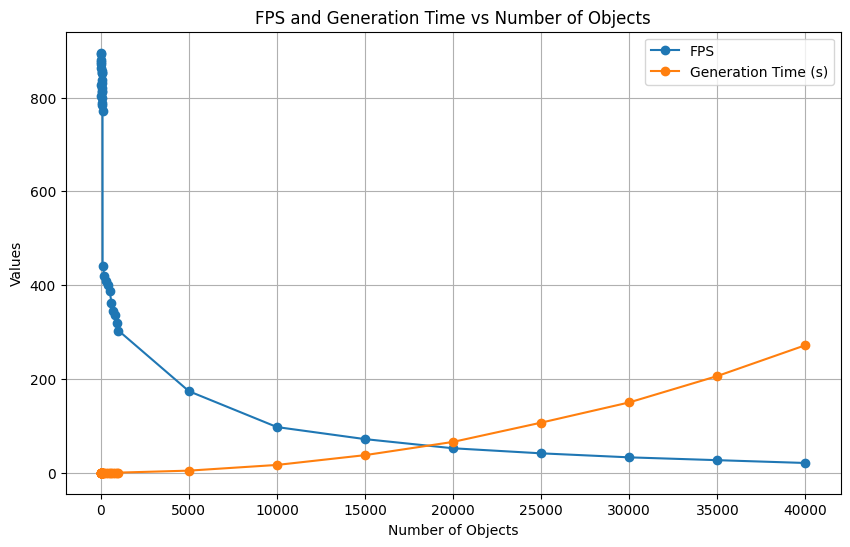

In [16]:
import matplotlib.pyplot as plt

num_objects = list(results.keys())
fps_values = [v[0] for v in results.values()]
generation_times = [v[1] for v in results.values()]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(num_objects, fps_values, label='FPS', marker='o')
plt.plot(num_objects, generation_times, label='Generation Time (s)', marker='o')

plt.xlabel('Number of Objects')
plt.ylabel('Values')
plt.title('FPS and Generation Time vs Number of Objects')
plt.legend()
plt.grid(True)

plt.show()


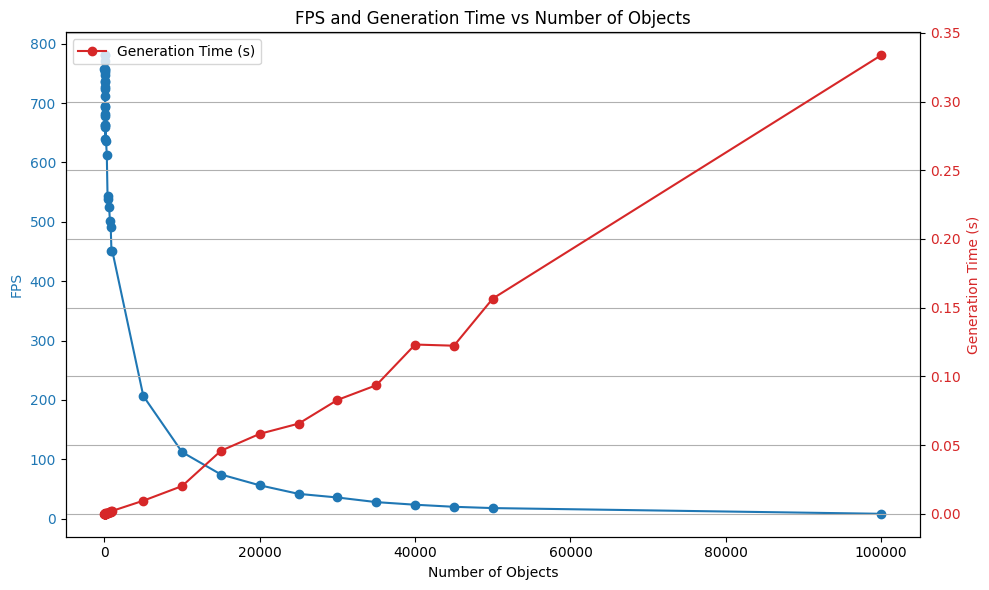

In [2]:
import matplotlib.pyplot as plt

# results1 = {1: (895.5832458699174, 0.008231401443481445), 5: (874.8947350169816, 0.008946418762207031), 10: (861.9517510324698, 0.0067234039306640625), 15: (803.4033510619589, 0.008788347244262695), 20: (826.4461108372362, 0.011795282363891602), 25: (892.2949024381811, 0.012117624282836914), 30: (880.817766568021, 0.010245561599731445), 35: (870.7990479559708, 0.011226654052734375), 40: (856.2405411467754, 0.009530782699584961), 45: (852.171281943518, 0.01001596450805664), 50: (852.4271657097851, 0.01156163215637207), 55: (838.039967717471, 0.012759923934936523), 60: (831.595780199258, 0.0122222900390625), 65: (820.7425999354139, 0.014039039611816406), 70: (813.8101676970061, 0.013093709945678711), 75: (811.8249181952104, 0.012933969497680664), 80: (799.3792770682517, 0.01446986198425293), 85: (788.8950743434195, 0.014393091201782227), 90: (783.6711882756115, 0.017041683197021484), 95: (771.6661333180548, 0.01423501968383789), 100: (761.0693111304771, 0.01479196548461914)}
# results2 ={100: (441.6851926149922, 0.02807760238647461), 200: (419.65448893830427, 0.028905630111694336), 300: (408.06818540429015, 0.042719364166259766), 400: (401.04018964273985, 0.05560708045959473), 500: (387.80391563178296, 0.07719802856445312), 600: (362.5535223776417, 0.10336446762084961), 700: (344.51494390683365, 0.13973140716552734), 800: (336.1252336785607, 0.15714693069458008), 900: (319.16115668374533, 0.1921098232269287), 1000: (303.07042293646634, 0.22408413887023926)}
# results3 = {5000: (173.79310336775754, 4.458710432052612), 10000: (97.34369737469942, 16.613506317138672), 15000: (71.63895361199617, 37.4998984336853), 20000: (52.126252868439764, 65.75739455223083), 25000: (41.32996647957075, 106.81102228164673), 30000: (32.796557206527396, 149.94286131858826), 35000: (26.769924945136474, 206.16963148117065), 40000: (20.769881932148966, 271.9198348522186)}
# results4 = {45000: (21.152451350178843, 333.5160973072052), 50000: (15.779823653917148, 419.4396266937256)}

# results = {**results1, **results2, **results3, **results4}


results = {1: (756.7142636953172, 6.818771362304688e-05), 5: (752.0861097157176, 3.5762786865234375e-05), 10: (734.9132354218076, 4.696846008300781e-05), 15: (727.8781218207665, 5.364418029785156e-05), 20: (780.570630921476, 6.699562072753906e-05), 25: (780.5667570325951, 7.843971252441406e-05), 30: (771.5408195393601, 8.7738037109375e-05), 35: (757.1901638574137, 8.559226989746094e-05), 40: (754.9551209939114, 0.00013756752014160156), 45: (746.5028062910591, 0.00010895729064941406), 50: (737.5422747017209, 0.00016498565673828125), 55: (723.0280682815153, 0.00011491775512695312), 60: (712.6428130626836, 0.00012969970703125), 65: (693.5795308717555, 0.00014162063598632812), 70: (695.8144345215716, 0.0001437664031982422), 75: (678.8263487015299, 0.00015616416931152344), 80: (660.3990626740696, 0.0002639293670654297), 85: (681.6050077356548, 0.00017642974853515625), 90: (662.8293364225015, 0.000232696533203125), 95: (639.2256790139359, 0.0001838207244873047), 100: (663.5511344044796, 0.0002162456512451172), 200: (636.7081478977428, 0.0003974437713623047), 300: (612.541197654669, 0.0005514621734619141), 400: (539.2367743158001, 0.0007376670837402344), 500: (543.0569581405757, 0.0009522438049316406), 600: (524.5067919926378, 0.0011074542999267578), 700: (501.52365841236576, 0.0014069080352783203), 800: (492.03959829569465, 0.0014514923095703125), 900: (450.6870372011422, 0.002003192901611328), 1000: (451.33616314847063, 0.0021398067474365234), 5000: (206.555131859612, 0.009563922882080078), 10000: (111.96632611732639, 0.020222902297973633), 15000: (74.30399053385449, 0.0458979606628418), 20000: (56.07695762063882, 0.058228254318237305), 25000: (41.67863349244524, 0.06564736366271973), 30000: (35.57793295180229, 0.08289575576782227), 35000: (27.791367130998825, 0.09359288215637207), 40000: (23.40653567488394, 0.12318563461303711), 45000: (19.905702272348964, 0.12233591079711914), 50000: (17.73415509242768, 0.1566476821899414), 100000: (8.120455127727444, 0.3336620330810547)}

num_objects = list(results.keys())
fps_values = [v[0] for v in results.values()]
generation_times = [v[1] for v in results.values()]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting FPS
color = 'tab:blue'
ax1.set_xlabel('Number of Objects')
ax1.set_ylabel('FPS', color=color)
ax1.plot(num_objects, fps_values, label='FPS', color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the generation time
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Generation Time (s)', color=color)
ax2.plot(num_objects, generation_times, label='Generation Time (s)', color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)


plt.title('FPS and Generation Time vs Number of Objects')
fig.tight_layout()
plt.legend()
plt.grid(True)

plt.show()






In [12]:
# results 1 to 100

results1 = {1: (895.5832458699174, 0.008231401443481445), 5: (874.8947350169816, 0.008946418762207031), 10: (861.9517510324698, 0.0067234039306640625), 15: (803.4033510619589, 0.008788347244262695), 20: (826.4461108372362, 0.011795282363891602), 25: (892.2949024381811, 0.012117624282836914), 30: (880.817766568021, 0.010245561599731445), 35: (870.7990479559708, 0.011226654052734375), 40: (856.2405411467754, 0.009530782699584961), 45: (852.171281943518, 0.01001596450805664), 50: (852.4271657097851, 0.01156163215637207), 55: (838.039967717471, 0.012759923934936523), 60: (831.595780199258, 0.0122222900390625), 65: (820.7425999354139, 0.014039039611816406), 70: (813.8101676970061, 0.013093709945678711), 75: (811.8249181952104, 0.012933969497680664), 80: (799.3792770682517, 0.01446986198425293), 85: (788.8950743434195, 0.014393091201782227), 90: (783.6711882756115, 0.017041683197021484), 95: (771.6661333180548, 0.01423501968383789), 100: (761.0693111304771, 0.01479196548461914)}



In [13]:
# results 100 to 1000
results1 = {1: (895.5832458699174, 0.008231401443481445), 5: (874.8947350169816, 0.008946418762207031), 10: (861.9517510324698, 0.0067234039306640625), 15: (803.4033510619589, 0.008788347244262695), 20: (826.4461108372362, 0.011795282363891602), 25: (892.2949024381811, 0.012117624282836914), 30: (880.817766568021, 0.010245561599731445), 35: (870.7990479559708, 0.011226654052734375), 40: (856.2405411467754, 0.009530782699584961), 45: (852.171281943518, 0.01001596450805664), 50: (852.4271657097851, 0.01156163215637207), 55: (838.039967717471, 0.012759923934936523), 60: (831.595780199258, 0.0122222900390625), 65: (820.7425999354139, 0.014039039611816406), 70: (813.8101676970061, 0.013093709945678711), 75: (811.8249181952104, 0.012933969497680664), 80: (799.3792770682517, 0.01446986198425293), 85: (788.8950743434195, 0.014393091201782227), 90: (783.6711882756115, 0.017041683197021484), 95: (771.6661333180548, 0.01423501968383789), 100: (761.0693111304771, 0.01479196548461914)}


results2 ={100: (441.6851926149922, 0.02807760238647461), 200: (419.65448893830427, 0.028905630111694336), 300: (408.06818540429015, 0.042719364166259766), 400: (401.04018964273985, 0.05560708045959473), 500: (387.80391563178296, 0.07719802856445312), 600: (362.5535223776417, 0.10336446762084961), 700: (344.51494390683365, 0.13973140716552734), 800: (336.1252336785607, 0.15714693069458008), 900: (319.16115668374533, 0.1921098232269287), 1000: (303.07042293646634, 0.22408413887023926)}
results3 = {5000: (173.79310336775754, 4.458710432052612), 10000: (97.34369737469942, 16.613506317138672), 15000: (71.63895361199617, 37.4998984336853), 20000: (52.126252868439764, 65.75739455223083), 25000: (41.32996647957075, 106.81102228164673), 30000: (32.796557206527396, 149.94286131858826), 35000: (26.769924945136474, 206.16963148117065), 40000: (20.769881932148966, 271.9198348522186)}

results4 = {45000: (21.152451350178843, 333.5160973072052), 50000: (15.779823653917148, 419.4396266937256), 100000: (7.910946864734796, 1765.4237129688263)}

In [20]:
# results for 5000 to 40000
results3 = {5000: (173.79310336775754, 4.458710432052612), 10000: (97.34369737469942, 16.613506317138672), 15000: (71.63895361199617, 37.4998984336853), 20000: (52.126252868439764, 65.75739455223083), 25000: (41.32996647957075, 106.81102228164673), 30000: (32.796557206527396, 149.94286131858826), 35000: (26.769924945136474, 206.16963148117065), 40000: (20.769881932148966, 271.9198348522186)}

results4 = {45000: (21.152451350178843, 333.5160973072052), 50000: (15.779823653917148, 419.4396266937256), 100000: (7.910946864734796, 1765.4237129688263)}

# combine all 3 results dict
results = {**results1, **results2}
results_high = {**results3, **results4}

In [7]:
import numpy as np

array = np.arange(1, 5000)
array 

array([   1,    2,    3, ..., 4997, 4998, 4999])

In [11]:
%%timeit
a = [{i : j} for i,j  in enumerate(array)]

1.57 ms ± 93.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
%%timeit
b = {}
for i, j in enumerate(array):
    b[i] = j

893 µs ± 8.05 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
# create a class that extends qgsgeometry

class MyQgsGeometry(QgsGeometry):
    def __init__(self, *args, **kwargs):
        super(MyQgsGeometry, self).__init__(*args, **kwargs)
        self._timestamp = None

    @property
    def timestamp(self):
        return self._timestamp

    @timestamp.setter
    def timestamp(self, value):
        self._timestamp = value

    def __str__(self):
        return f"{self.asWkt()} - {self.timestamp}"

In [ ]:
import pickle
a = QgsGeometry()


# dump a in a pickle file
with open('a.pkl', 'wb') as f:
    pickle.dump(a, f)

In [ ]:
vlayer = QgsVectorLayer("Point", "name", "memory")
pr = vlayer.dataProvider()
#pr.addAttributes([QgsField("start_time", QVariant.DateTime), QgsField("end_time", QVariant.DateTime)])
vlayer.updateFields()
tp = vlayer.temporalProperties()
tp.setIsActive(True)
tp.setMode(qgis.core.QgsVectorLayerTemporalProperties.ModeFeatureDateTimeStartAndEndFromFields)
tp.setStartField("start_time")
tp.setEndField("end_time")

QgsProject.instance().addMapLayer(vlayer)

vfields = vlayer.fields()
now = time.time()
features_list =[ QgsFeature(vfields) for _ in range(num_fields)]

vlayer.startEditing()
vlayer.addFeatures(features_list)
vlayer.commitChanges()
iface.vectorLayerTools().stopEditing(vlayer)

# start_datetime_obj = QDateTime(datetime(2023,6,1,0,0,0))
# end_datetime_obj = QDateTime(datetime(2023,6,1,23,0,0))


# for i in range(num_fields):
#     feat = QgsFeature().setAttributes([start_datetime_obj, end_datetime_obj])
#     # geom = QgsGeometry()
#     # feat.setGeometry(geom)
#     features_list.append(feat)






TIME_create_features = time.time() - now




In [ ]:
num_features = 30000

now=time.time()

feats = [QgsFeature(vlayer.fields()) for _ in range(num_features)]

feats = [feat.setAttributes([start_datetime_obj, end_datetime_obj]) for feat in feats]

createtime = time.time() - now
print(createtime)

now2 = time.time()

vlayer.startEditing()
vlayer.addFeatures(feats)
vlayer.commitChanges()
iface.vectorLayerTools().stopEditing(vlayer)
addtime= time.time() - now2
print(f"add part: {addtime}, total : {createtime + addtime}")

In [ ]:
from datetime import datetime
num_fields = 50000
vlayer = QgsVectorLayer("Point", "name", "memory")
pr = vlayer.dataProvider()
pr.addAttributes([QgsField("start_time", QVariant.DateTime), QgsField("end_time", QVariant.DateTime)])
vlayer.updateFields()
tp = vlayer.temporalProperties()
tp.setIsActive(True)
tp.setMode(qgis.core.QgsVectorLayerTemporalProperties.ModeFeatureDateTimeStartAndEndFromFields)
tp.setStartField("start_time")
tp.setEndField("end_time")
QgsProject.instance().addMapLayer(vlayer)

start_datetime_obj = QDateTime(datetime(2023,6,1,0,0,0))
end_datetime_obj = QDateTime(datetime(2023,6,1,23,0,0))
vfields = vlayer.fields()

num_fields = 50000
import time
times = []
rec = []
for i in range(num_fields):
    now = time.time()
    feat = QgsFeature(vfields)
    feat.setAttributes([start_datetime_obj, end_datetime_obj])
    rec.append(feat)
    times.append(time.time() - now)

now = time.time()

pr.addFeatures(rec)

print(time.time() - now)


In [ ]:
TIME_create_features = time.time() - now

current_time_stamp_column = ["POINT (1 1)"]*num_fields

fps_record = []
for i in range(frames):
    start_time = time.time()    
    current_time_stamp_column = ["POINT (1 1)"]*num_fields
    new_geometries = {}  # Dictionary {feature_id: QgsGeometry}
    for j in range(num_fields): #TODO : compare vs Nditer
        new_geometries[j] = QgsGeometry.fromWkt(current_time_stamp_column[j])


    vlayer.startEditing()
    # self.qviz.vlayer.dataProvider().changeAttributeValues(attribute_changes) # Updating attribute values for all features
    vlayer.dataProvider().changeGeometryValues(new_geometries) # Updating geometries for all features
    vlayer.commitChanges()
    iface.vectorLayerTools().stopEditing(vlayer)


    end_time = time.time()
    fps_record.append(1/(end_time-start_time))

    average_fps = sum(fps_record)/len(fps_record)

# Upper bound for matrix time

In [1]:
from pymeos import *
pymeos_initialize()

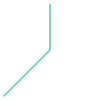

In [1]:
from shapely.geometry import Point, LineString, Polygon

line = LineString([(0, 0), (1, 1), (1, 2)])
line

In [4]:
start_line = TGeomPointInst(line, timestamp="2023-06-01")

AttributeError: 'LineString' object has no attribute 'encode'

In [2]:
start_point = TGeomPointInst(point=(0,0), timestamp="2023-06-01")
start_point

TGeomPointInst(POINT(0 0)@2023-06-01 00:00:00+02)

In [3]:
end_point = TGeomPointInst(point=(1,1), timestamp="2023-06-01 0:59:00")
end_point

TGeomPointInst(POINT(1 1)@2023-06-01 00:59:00+02)

In [6]:
from shapely.geometry import Point, LineString, Polygon


'LINESTRING (0 0, 1 1)'

In [25]:
%%timeit
line = LineString([start_point.values()[0], end_point.values()[0]])
line.wkt

26.5 µs ± 181 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [22]:
start_point.values()[0].y

0.0

In [26]:
%%timeit
val = f"LINESTRING ( {start_point.values()[0].x} {start_point.values()[0].y} , {end_point.values()[0].x} {end_point.values()[0].y} )"
val

29.3 µs ± 380 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [23]:
traj = TGeomPointSeq.from_instants([start_point, end_point], upper_inc=True)
traj

TGeomPointSeq([POINT(0 0)@2023-06-01 00:00:00+02, POINT(1 1)@2023-06-01 00:59:00+02])

In [1]:
from datetime import datetime, timedelta
start = datetime(2023,6,1,0,0,0)
end = datetime(2023,6,1,23,59,59)
start

datetime.datetime(2023, 6, 1, 0, 0)

In [25]:
traj_resampled = traj.temporal_sample(start=start,duration= timedelta(minutes=1))
traj_resampled                    

TGeomPointSeq({POINT(0 0)@2023-06-01 00:00:00+02, POINT(0.016949152542373 0.016949152542373)@2023-06-01 00:01:00+02, POINT(0.033898305084746 0.033898305084746)@2023-06-01 00:02:00+02, POINT(0.050847457627119 0.050847457627119)@2023-06-01 00:03:00+02, POINT(0.067796610169492 0.067796610169492)@2023-06-01 00:04:00+02, POINT(0.084745762711864 0.084745762711864)@2023-06-01 00:05:00+02, POINT(0.101694915254237 0.101694915254237)@2023-06-01 00:06:00+02, POINT(0.11864406779661 0.11864406779661)@2023-06-01 00:07:00+02, POINT(0.135593220338983 0.135593220338983)@2023-06-01 00:08:00+02, POINT(0.152542372881356 0.152542372881356)@2023-06-01 00:09:00+02, POINT(0.169491525423729 0.169491525423729)@2023-06-01 00:10:00+02, POINT(0.186440677966102 0.186440677966102)@2023-06-01 00:11:00+02, POINT(0.203389830508475 0.203389830508475)@2023-06-01 00:12:00+02, POINT(0.220338983050847 0.220338983050847)@2023-06-01 00:13:00+02, POINT(0.23728813559322 0.23728813559322)@2023-06-01 00:14:00+02, POINT(0.25423728

In [26]:
len(traj_resampled.values())

60

In [2]:
import numpy as np

empty_point_wkt = "POINT EMPTY"

matrix = np.full((100, 100), empty_point_wkt, dtype=object)
matrix

array([['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ...,
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY']], dtype=object)

In [3]:
index = 4 
remainder = 5 - index


b = matrix[:, 0:index]

In [4]:
matrix2 = np.full((100, 100), empty_point_wkt, dtype=object)
matrix2

array([['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ...,
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY']], dtype=object)

In [5]:
a = matrix2[:, (100-remainder):100] 

In [9]:

combined_matrix = np.concatenate((a, b), axis=1)
combined_matrix

array([['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY',
        'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY',
        'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY',
        'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY',
        'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY',
        'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY',
        'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY',
        'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY',
        'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY',
        'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY',
        'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY',
        'POI

In [17]:
list(combined_matrix[0])

['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY']

In [18]:
LineString(['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY'])

ValueError: could not convert string to float: 'P'